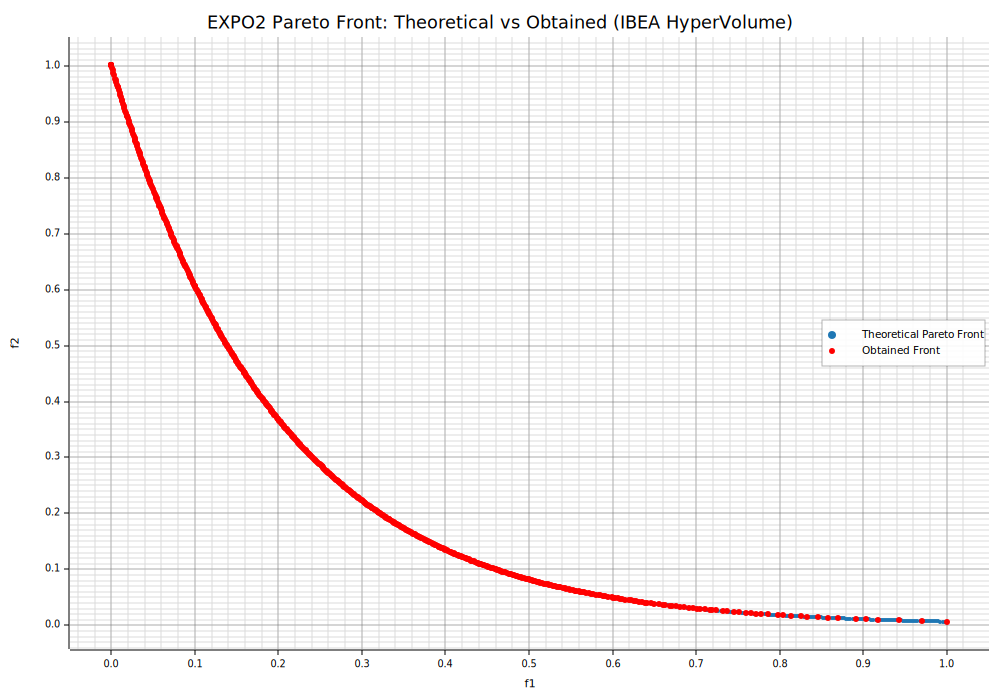

In [ ]:
:dep ndarray = "*"
:dep moors = "*"
:dep plotters = "0.3.6"

use ndarray::{array, Array2, Axis, Ix2, s};
use moors::{
    impl_constraints_fn,
    algorithms::IbeaBuilder,
    duplicates::CloseDuplicatesCleaner,
    operators::{GaussianMutation, RandomSamplingFloat, SimulatedBinaryCrossover},
    genetic::Population
};
use plotters::prelude::*;


// ==============================
// EXPO2 — Objective Evaluation
// ==============================
fn evaluate_expo2(genes: &Array2<f64>) -> Array2<f64> {
    /// EXPO2 (minimization, 2 objectives).
    ///
    /// g(x) = 1 + (9/(n-1)) * sum_{i=2..n} x_i
    /// f1(x) = x1
    /// f2(x) = g(x) * exp( -5 * x1 / g(x) )
    ///
    /// Typical domain: x_i in [0, 1], i=1..n (e.g., n = 30).
    let n = genes.nrows();
    let m = genes.ncols();
    if m < 2 {
        panic!("EXPO2 requires at least 2 decision variables.");
    }

    // g(x)
    let tail = genes.slice(s![.., 1..]);
    let sums = tail.sum_axis(Axis(1));
    let g = sums.mapv(|s| 1.0 + (9.0 / ((m as f64) - 1.0)) * s);

    let f1 = genes.column(0).to_owned();
    let f2 = g.iter().zip(f1.iter()).map(|(gi, &f1i)| gi * (-5.0 * f1i / gi).exp()).collect::<Vec<_>>();

    let mut result = Array2::<f64>::zeros((n, 2));
    result.column_mut(0).assign(&f1);
    result.column_mut(1).assign(&Array2::from_shape_vec((n, 1), f2).unwrap().column(0));
    result
}


// ==========================================
// Theoretical Front (g=1 => x2..xn = 0; f2=exp(-5 f1))
// ==========================================
// Returns (f1, f2) arrays of the EXPO2 Pareto front:
//      f1 in [0, 1], f2 = exp(-5 f1)
fn expo2_theoretical_front(num_points: usize) -> (Vec<f64>, Vec<f64>) {
    let mut f1_theo = Vec::with_capacity(num_points);
    let mut f2_theo = Vec::with_capacity(num_points);
    for i in 0..num_points {
        let t = if num_points <= 1 { 0.0 } else { i as f64 / (num_points as f64 - 1.0) };
        f1_theo.push(t);
        f2_theo.push((-5.0 * t).exp());
    }
    (f1_theo, f2_theo)
}


// =============================
// Algorithm Setup (IBEA-H)
// =============================
// Problem dimensionality

impl_constraints_fn!(BoundConstraints, lower_bound = 0.0, upper_bound = 1.0);

let population: Population<Ix2, Ix2> = {
    let num_vars: usize = 30;
    // Hypervolume reference point (minimization ⇒ worse-than-worst)
    // We put [4.0, 4.0] far from the normalized range [0,1]
    let hv_reference = array![4.0, 4.0];
    // kappa controls the selection pressure in IBEA
    let kappa = 0.05;

    let mut algorithm = IbeaBuilder::default()
        .sampler(RandomSamplingFloat::new(0.0, 1.0))
        .crossover(SimulatedBinaryCrossover::new(15.0))
        .mutation(GaussianMutation::new(0.1, 0.1))
        .reference(hv_reference.clone()) // clone because we will plot it later
        .kappa(kappa)
        .duplicates_cleaner(CloseDuplicatesCleaner::new(1e-6))
        .fitness_fn(evaluate_expo2)
        .constraints_fn(BoundConstraints)
        .num_vars(num_vars)
        .population_size(600)
        .num_offsprings(600)
        .num_iterations(600)
        .mutation_rate(0.2)
        .crossover_rate(0.9)
        .keep_infeasible(false)
        .verbose(false)
        .seed(1)
        .build()
        .expect("Failed to build IBEA");

    // ===============
    // Run IBEA
    // ===============
    algorithm.run().expect("IBEA run failed");
    algorithm.population.unwrap().clone()
};

// Best front (Population)
let fitness = population.fitness;
let f1_found: Vec<f64> = fitness.column(0).to_vec();
let f2_found: Vec<f64> = fitness.column(1).to_vec();

let (f1_theo, f2_theo) = expo2_theoretical_front(400);

// Plot the theoretical Pareto front, obtained front, and reference points
let mut svg = String::new();
{
    let backend = SVGBackend::with_string(&mut svg, (1000, 700));
    let root = backend.into_drawing_area();
    root.fill(&WHITE).unwrap();

    let (mut x_min, mut x_max) = (f1_theo[0], f1_theo[0]);
    let (mut y_min, mut y_max) = (f2_theo[0], f2_theo[0]);

    for &x in f1_theo.iter().chain(f1_found.iter()) {
        if x < x_min { x_min = x; }
        if x > x_max { x_max = x; }
    }
    for &y in f2_theo.iter().chain(f2_found.iter()) {
        if y < y_min { y_min = y; }
        if y > y_max { y_max = y; }
    }

    let xr = (x_max - x_min).max(1e-9);
    let yr = (y_max - y_min).max(1e-9);
    x_min -= xr * 0.05;
    x_max += xr * 0.05;
    y_min -= yr * 0.05;
    y_max += yr * 0.05;

    let mut chart = ChartBuilder::on(&root)
        .caption("EXPO2 Pareto Front: Theoretical vs Obtained (IBEA HyperVolume)", ("DejaVu Sans", 22))
        .margin(10)
        .x_label_area_size(40)
        .y_label_area_size(60)
        .build_cartesian_2d(x_min..x_max, y_min..y_max)
        .unwrap();

    chart.configure_mesh()
        .x_desc("f1")
        .y_desc("f2")
        .axis_desc_style(("DejaVu Sans", 14))
        .light_line_style(&RGBColor(220, 220, 220))
        .draw()
        .unwrap();

    chart.draw_series(
        f1_theo.iter().zip(f2_theo.iter()).map(|(&x, &y)| {
            Circle::new((x, y), 2, RGBColor(31, 119, 180).filled())
        })
    ).unwrap()
     .label("Theoretical Pareto Front")
     .legend(|(x, y)| Circle::new((x, y), 4, RGBColor(31, 119, 180).filled()));

    chart.draw_series(
        f1_found.iter().zip(f2_found.iter()).map(|(&x, &y)| {
            Circle::new((x, y), 3, RGBColor(255, 0, 0).filled())
        })
    ).unwrap()
     .label("Obtained Front")
     .legend(|(x, y)| Circle::new((x, y), 3, RGBColor(255, 0, 0).filled()));

    chart.configure_series_labels()
        .border_style(&RGBAColor(0, 0, 0, 0.3))
        .background_style(&WHITE.mix(0.9))
        .label_font(("DejaVu Sans", 13))
        .draw()
        .unwrap();

    root.present().unwrap();
}

println!("EVCXR_BEGIN_CONTENT image/svg+xml\n{}\nEVCXR_END_CONTENT", svg);